In [1]:
import numpy as np
import matplotlib.pyplot as plt
import corner
import emcee

import config
import parameter_estimation_measured_f_a

PARAMETER  INITIAL-VALUE    INITIAL-ERROR   MCMC-MEAN      +MCMC-ERR      -MCMC-ERR
theta_i    1.000000e+00 +/- 0.000000e+00 vs 9.665695e-01 + 4.264157e-02 - 3.464464e-02
f_a        1.000000e+21 +/- 1.000000e+15 vs 9.999999e+20 + 1.036636e+15 - 1.063919e+15
M_pl       2.435403e+27 +/- 2.792596e+22 vs 2.435404e+27 + 3.073909e+22 - 2.977356e+22
Lambda_QCD 2.000000e+08 +/- 2.000000e+07 vs 2.004588e+08 + 2.169709e+07 - 2.278173e+07
m_u        2.300000e+06 +/- 3.750000e+05 vs 2.252662e+06 + 4.637651e+05 - 5.129372e+05
m_d        4.800000e+06 +/- 3.250000e+05 vs 4.808993e+06 + 3.735664e+05 - 3.562405e+05
m_pi       1.349770e+08 +/- 5.000000e+02 vs 1.349769e+08 + 5.182556e+02 - 5.399057e+02
f_pi       9.192388e+07 +/- 5.000000e+06 vs 9.211466e+07 + 6.179203e+06 - 6.790438e+06
T0         2.348653e-04 +/- 5.170398e-09 vs 2.348649e-04 + 5.831504e-09 - 5.567535e-09
rho_c      3.667106e-11 +/- 9.808371e-14 vs 3.667014e-11 + 1.030541e-13 - 1.035164e-13


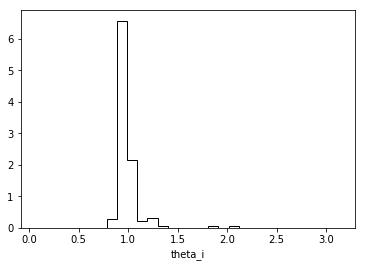

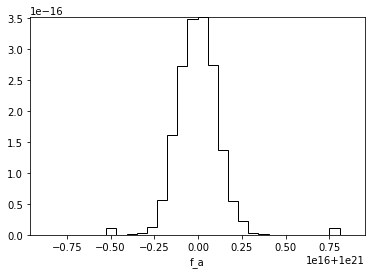

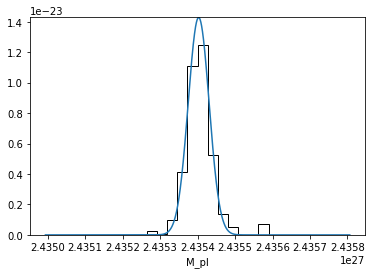

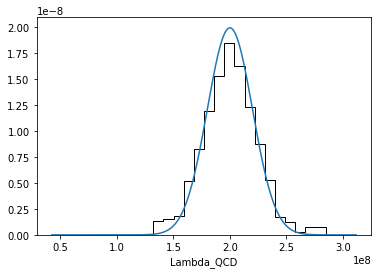

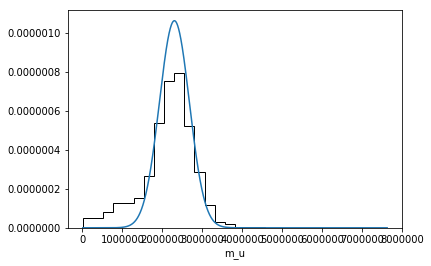

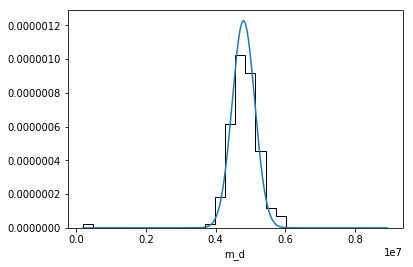

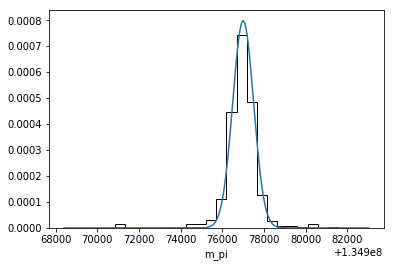

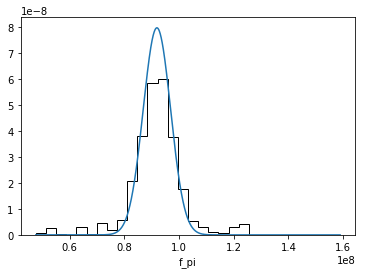

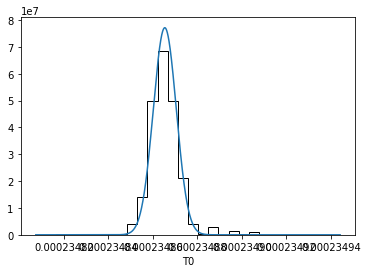

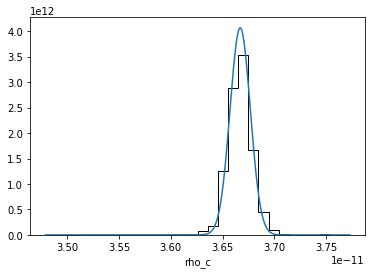

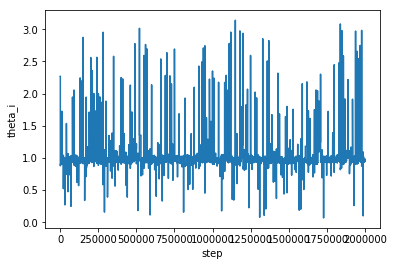

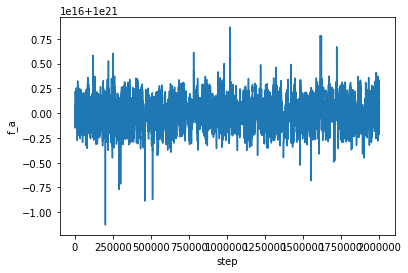

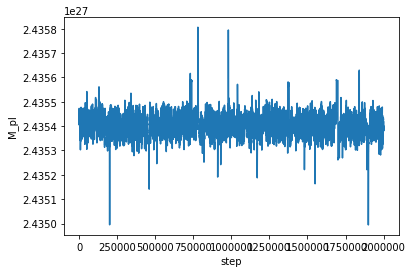

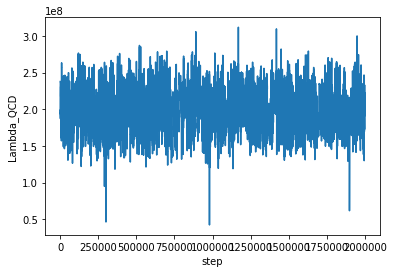

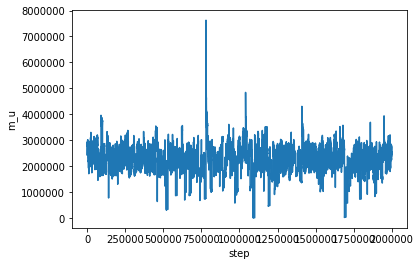

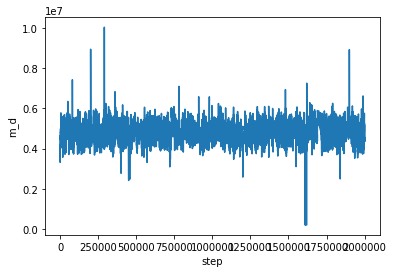

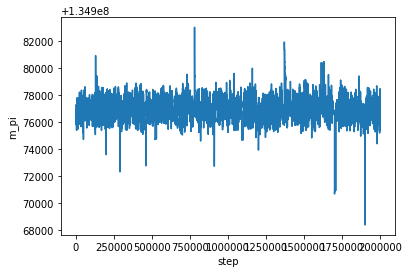

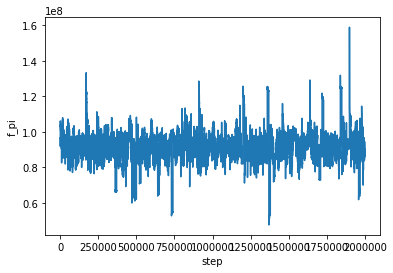

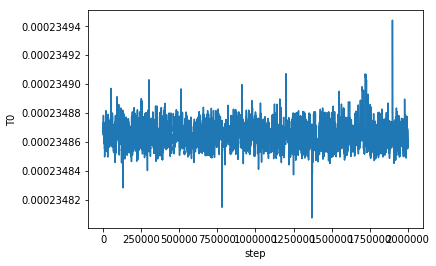

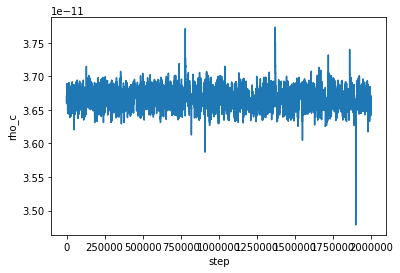

Text(0.5,0,'f_a')

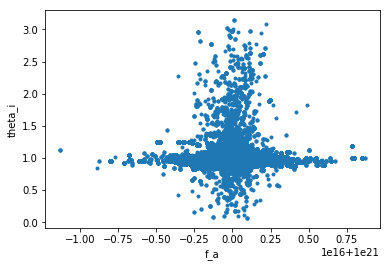

In [6]:
filename = "parameter_f_a_measured.npz"
df = np.load(config.data_path + "/" + filename)
samples = df["samples"].reshape((-1, len(parameter_estimation_measured_f_a.inital_guess)))

# compute parameter including error bounds
if "parameter" in df:
    parameter = df["parameter"]
else:
    #                          mean value, lower error, upper error
    parameter = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))

# print table of parameters
print("PARAMETER  INITIAL-VALUE    INITIAL-ERROR   MCMC-MEAN      +MCMC-ERR      -MCMC-ERR")
for name, ip, ie, p in zip(parameter_estimation_measured_f_a.parameter_names, 
                           parameter_estimation_measured_f_a.inital_guess, 
                           parameter_estimation_measured_f_a.errors, parameter):
    print(name + " " * (len("Lambda_QCD") - len(name)), 
          "%e" % ip, "+/-", "%e" % ie, "vs", "%e" % p[0], "+", "%e" % p[1], "-", "%e" % p[2])

# corner plots
#try:
#    corner.corner(samples, labels=parameter_estimation.parameter_names)
#except:
#    pass
#plt.show()

# histograms for each parameter including priors
for i, (name, x0, x_err) in enumerate(zip(parameter_estimation_measured_f_a.parameter_names,
                                          parameter_estimation_measured_f_a.inital_guess,
                                          parameter_estimation_measured_f_a.errors)):
    ps = samples[:, i]
    ps = ps[ps.size // 4 :]
    if i > 1:
        vals = np.linspace(np.min(ps), np.max(ps), ps.size)
        plt.plot(vals, np.exp(- (vals - x0)**2 / (2 * x_err**2)) / np.sqrt(2 * np.pi * x_err**2))
    try:
        plt.hist(ps, histtype="step", bins=30, density=True, color="black")
    except:
        print(name, "doesnt work")
    plt.xlabel(name)
    plt.show()

# samples 
for i, name in enumerate(parameter_estimation_measured_f_a.parameter_names):
    plt.plot(samples[:, i])
    plt.ylabel(name)
    plt.xlabel("step")
    plt.show()

# scatter theta_i vs f_a
plt.plot(samples[:, 1], samples[:, 0], ".")
plt.ylabel("theta_i")
plt.xlabel("f_a")

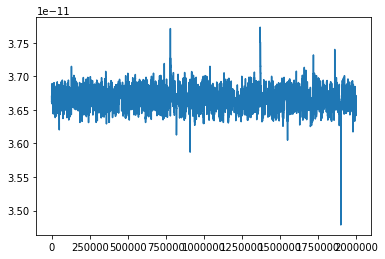

In [4]:
s = df["samples"]
chain = s.reshape((-1, parameter_estimation_measured_f_a.ndim))
plt.plot(chain[:, -1])
fn = emcee.autocorr.function(chain)

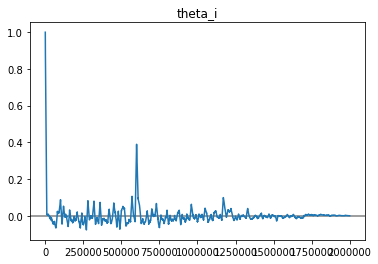

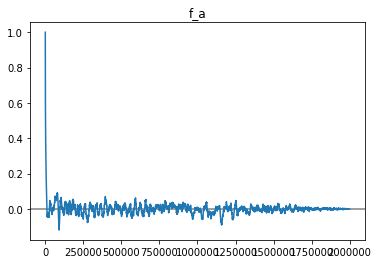

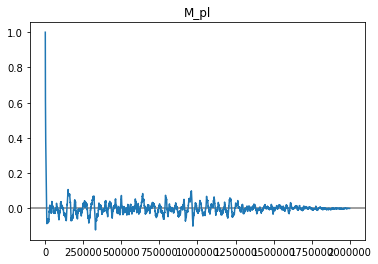

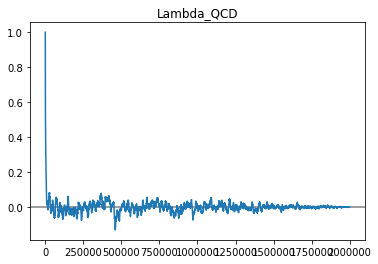

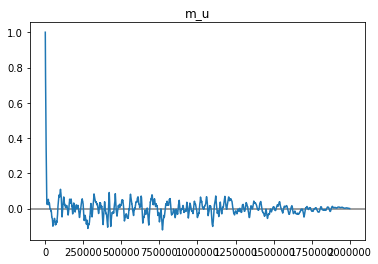

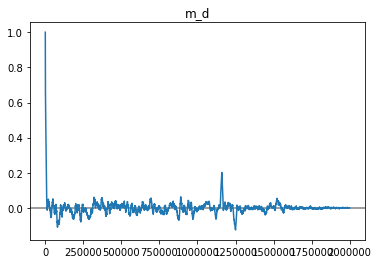

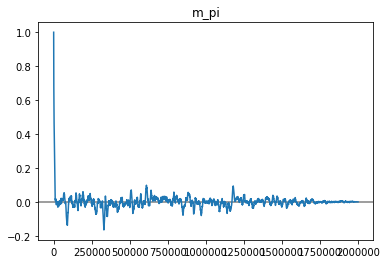

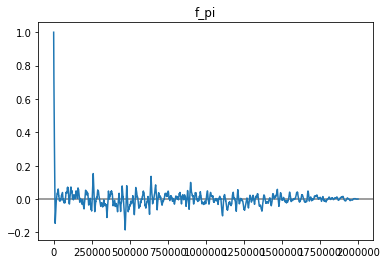

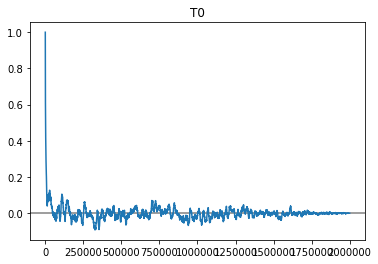

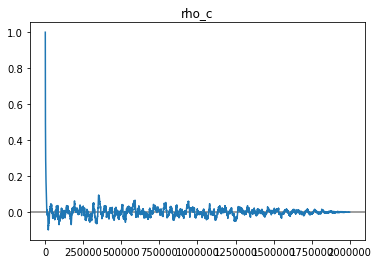

In [5]:
for i, name in enumerate(parameter_estimation_measured_f_a.parameter_names):
    plt.axhline(0, color="grey")
    plt.plot(fn[:, i])
    plt.title(name)
    plt.show()